<a href="https://colab.research.google.com/github/ProvenDruid/CNNs/blob/main/cnn_FMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset,Subset
import copy
from sklearn.model_selection import train_test_split


# for importing data
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
from IPython import display
from matplotlib_inline.backend_inline import set_matplotlib_formats

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.Normalize(.5,.5)
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform)
devset  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devset,  batch_size=batchsize,shuffle=True,drop_last=True) # note: devtest in batches!


In [ ]:
categories=trainset.classes
labels=trainset.targets

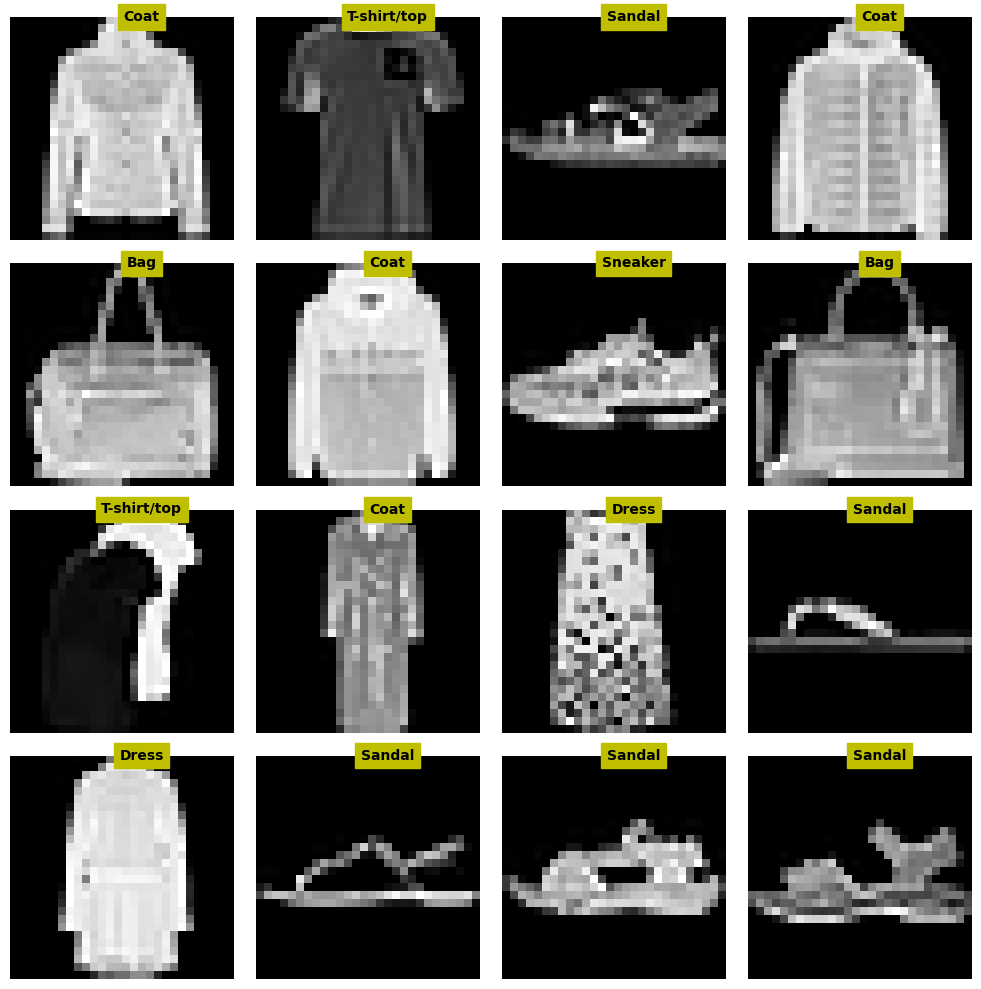

In [ ]:
# inspect a few random images
X,y = next(iter(train_loader))
fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = np.squeeze(X.data[i])
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = categories[y[i]]

  # and show!
  ax.imshow(pic, cmap="gray")
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class cifarnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(1,32,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(32) # input the number of channels in this layer
      # output size: 28/2 = 14 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(32,64,3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(64) # input the number of channels in this layer
      # output size: 14/2 = 7 (/2 b/c maxpool)

      # third convolution layer
      self.conv3  = nn.Conv2d(64,128,3,padding=1)
      self.bnorm3 = nn.BatchNorm2d(128) # input the number of channels in this layer
      # output size: 7/2 = 3 (/2 b/c maxpool)

      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(3*3*128,128)
      self.fc2 = nn.Linear(128,64)
      self.fc3 = nn.Linear(64,32)
      self.fc4 = nn.Linear(32,10)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      if self.print: print(f'Third CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.leaky_relu(self.fc2(x))
      x = F.leaky_relu(self.fc3(x))
      x = self.fc4(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = cifarnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

Input: [32, 1, 28, 28]
First CPR block: [32, 32, 14, 14]
Second CPR block: [32, 64, 7, 7]
Third CPR block: [32, 128, 3, 3]
Vectorized: [32, 1152]
Final output: [32, 10]

Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.3030, grad_fn=<NllLossBackward0>)


In [ ]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc   = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)



    ### test performance
    net.eval()
    batchAcc  = []
    batchLoss = []
    for X,y in dev_loader:
      # push data to GPU
      X = X.to(device)
      y = y.to(device)
      with torch.no_grad(): # deactivates autograd
        yHat = net(X)
        loss = lossfun(yHat,y)

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # get loss and error rate from the test batch
    devLoss[epochi] = loss.item()
    devAcc[epochi]  = 100*np.mean(batchAcc)

  # end epochs

  # function output
  return trainLoss,devLoss,trainAcc,devAcc,net

In [ ]:
# ~3 minutes with 10 epochs on GPU (8 mins on the CPU!)
trainLoss,devLoss,trainAcc,devAcc,net = function2trainTheModel()

In [ ]:
net.eval() # switch to test mode
X,y = next(iter(dev_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = net(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLoss = loss.item()
testAcc  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

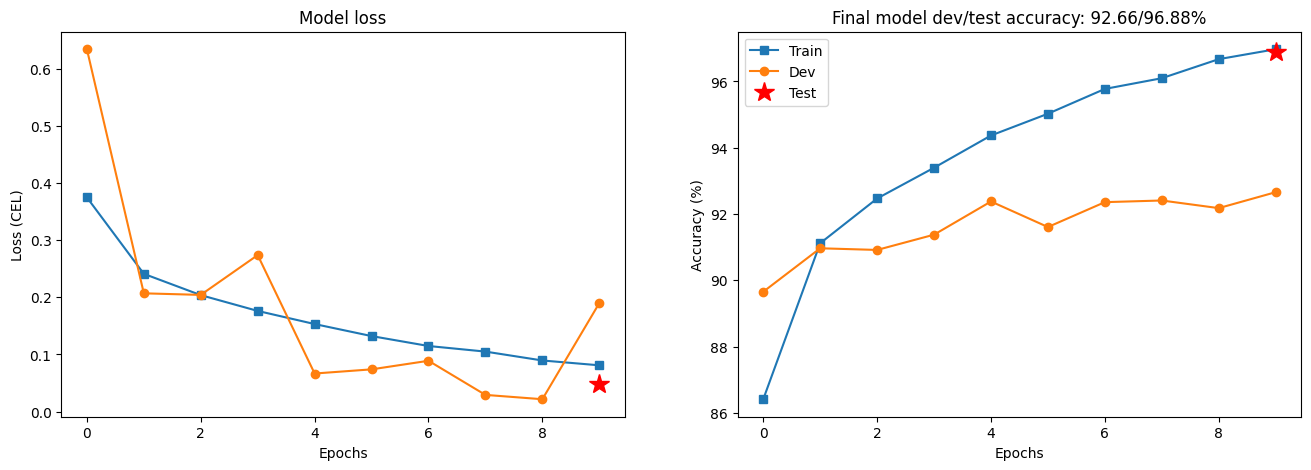

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].plot(len(devLoss)-1,testLoss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].plot(len(devAcc)-1,testAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAcc[-1]:.2f}/{testAcc:.2f}%')
ax[1].legend()

plt.show()

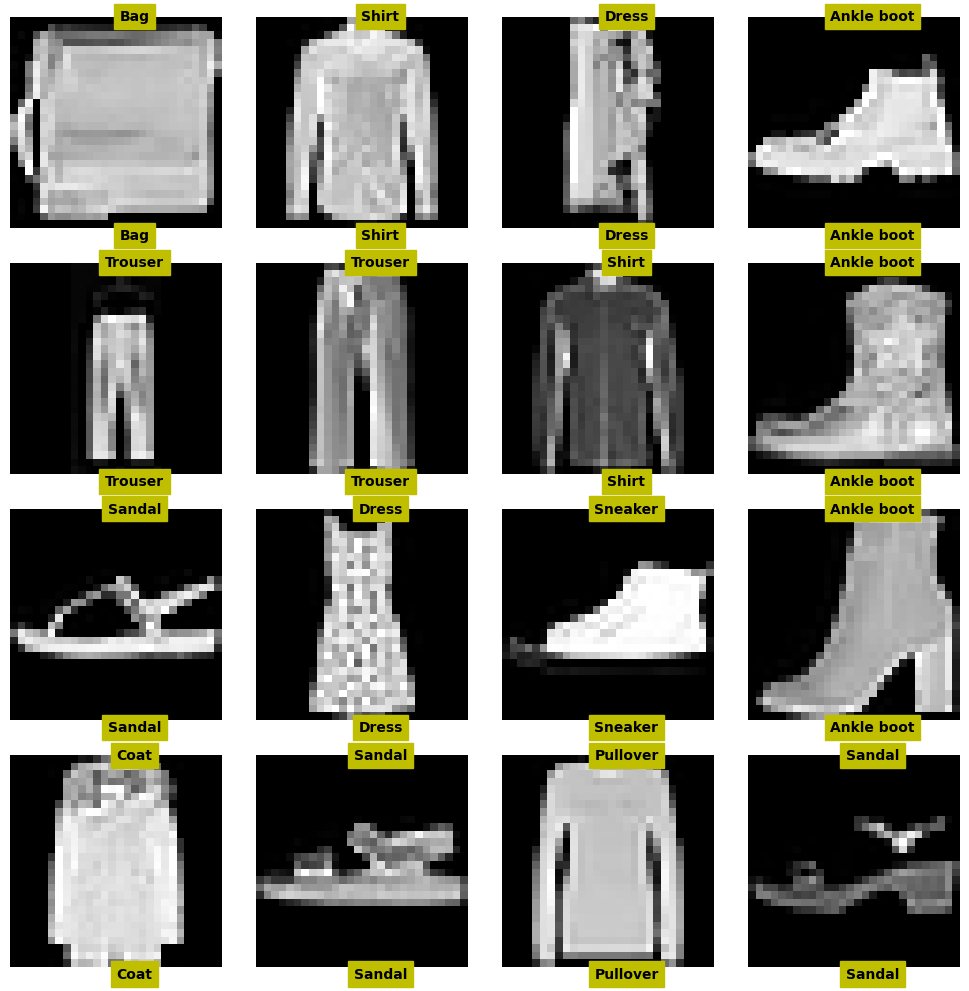

In [ ]:
# inspect a few random images
lastPhotos=X[0:16]
trueObjects=y[0:16]
predictions=torch.argmax(yHat[0:16],axis=1)
categories=trainset.classes
fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = np.squeeze(lastPhotos[i].cpu())
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = categories[trueObjects[i]]
  myGuess=categories[predictions[i]]
  # and show!
  ax.imshow(pic, cmap="gray")
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.text(16,29,myGuess,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()